In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("D:\\DRUG\\Drug_CNN\\data_for_gnn.tsv",sep='\t')

In [3]:
atoms={}
i=0
maxm=0
for x in df['smiles']:
    maxm=max(maxm,len(x))
    for j in x:
        if j not in atoms:
            atoms[j]=i
            i+=1


In [4]:
maxm

3821

In [5]:
len(atoms)

36

In [1]:
# from collections import defaultdict

# import numpy as np

# from rdkit import Chem

# import torch

In [6]:
input_data=[]
for x,y in zip(df['smiles'],df['for_cancer']):
    tsr=[[0]*maxm for i in range(len(atoms))]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    input_data.append([tsr,y])


In [7]:
import numpy as np

In [9]:
def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    np.random.seed(1234)  # fix the seed for shuffle.
    np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]

In [10]:
dataset_train, dataset_test=split_dataset(input_data,0.7)

In [11]:
train_gen=np.array([np.array(x[0]).reshape(36,3821,1) for x in dataset_train])
train_lab=np.array([x[1] for x in dataset_train])
test_gen=np.array([np.array(x[0]).reshape(36,3821,1) for x in dataset_test])
test_lab=np.array([x[1] for x in dataset_test])

In [12]:
train_gen[0].shape

(36, 3821, 1)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor="accuracy",min_delta=0.1,patience=4,verbose=1,mode='auto')
# mc=ModelCheckpoint(monitor="accuracy",filepath="/content/drive/MyDrive/Final Year Project/skinmodel.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es]

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,GaussianNoise,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [16]:
train_gen.shape

(1395, 36, 3821, 1)

In [17]:
import tensorflow as tf
# base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',input_shape=(256,256,1), include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# with tf.device('/GPU:0'):
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu',padding='Same', input_shape=(36,3821,1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 3821, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 1910, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 1908, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 954, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 244224)            0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

In [19]:

              
hs=model.fit(
    train_gen,
    train_lab,
    batch_size=16,
    epochs=8,
    verbose=1,  
    validation_data=(test_gen,test_lab),
    callbacks=cd
    )


Epoch 1/8
88/88 [==============================] - 28s 234ms/step - loss: 0.5922 - accuracy: 0.6953 - precision: 0.6203 - recall: 0.2117 - val_loss: 0.5630 - val_accuracy: 0.7040 - val_precision: 0.8000 - val_recall: 0.1932
Epoch 2/8
88/88 [==============================] - 13s 147ms/step - loss: 0.4751 - accuracy: 0.7692 - precision: 0.7390 - recall: 0.4708 - val_loss: 0.4533 - val_accuracy: 0.7609 - val_precision: 0.6758 - val_recall: 0.5942
Epoch 3/8
88/88 [==============================] - 13s 146ms/step - loss: 0.3581 - accuracy: 0.8416 - precision: 0.8343 - recall: 0.6523 - val_loss: 0.3331 - val_accuracy: 0.8679 - val_precision: 0.8404 - val_recall: 0.7633
Epoch 4/8
88/88 [==============================] - 13s 147ms/step - loss: 0.2464 - accuracy: 0.9082 - precision: 0.8781 - recall: 0.8402 - val_loss: 0.2791 - val_accuracy: 0.8645 - val_precision: 0.8841 - val_recall: 0.7005
Epoch 5/8
88/88 [==============================] - 13s 147ms/step - loss: 0.1749 - accuracy: 0.9405 - pr

In [20]:
def predict_output(x):
    tsr=[[0]*maxm for i in range(36)]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    tsr=np.array(tsr).reshape(36,3821,1)
    res=model.predict(np.array([tsr,]))
    if(res[0][0]>0.6):
        print("the drugs will interact with adenosine with probability " + str(res[0][0]))
    else:
        print("the drugs will not interact with adenosine")

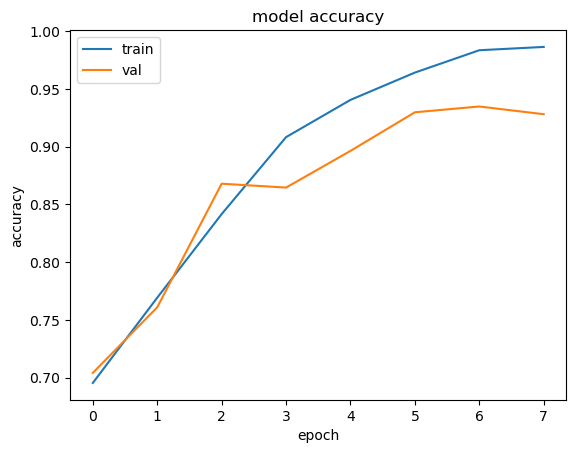

In [21]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

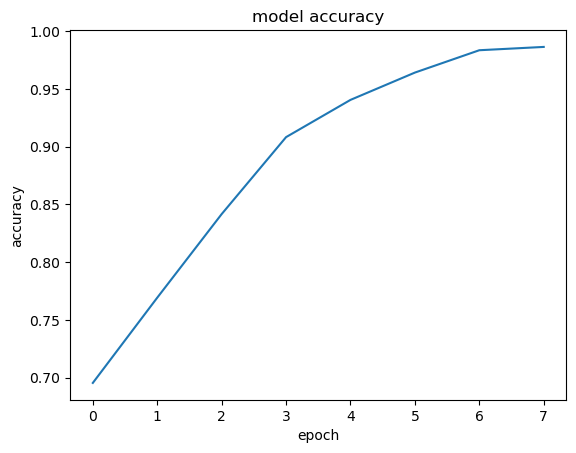

In [24]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

In [22]:
x="CC(C)(O)C1=C(CC[C@@H](SCC2(CC(O)=O)CC2)C2=CC(\C=C\C3=NC4=CC(Cl)=CC=C4C=C3)=CC=C2)C=CC=C1"
predict_output(x)

1/1 [==============================] - 0s 351ms/step
the drugs will interact with adenosine with probability 0.99922884


In [23]:
x="CC(C)(CO)C1=CC2=C(C=C(F)C(NC(=O)C3(CC3)C3=CC=C4OC(F)(F)OC4=C3)=C2)N1C[C@@H](O)CO"
predict_output(x)

1/1 [==============================] - 0s 34ms/step
the drugs will not interact with adenosine


In [75]:
tsr.shape

AttributeError: 'list' object has no attribute 'shape'

In [27]:
model.predict(np.array([tsr,]))

1/1 [==============================] - 0s 26ms/step


array([[2.0895238e-06]], dtype=float32)